In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import gdown

## Loading and cleaning

In [2]:
# # Loading data from GDrive.
# 
# # Data with BDL merged,
# file_id = "1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN"
# url = f"https://drive.google.com/uc?id={file_id}"
# file_extension = "downloaded_file.csv"
# gdown.download(url, file_extension, quiet=False)
# df = pd.read_csv(file_extension, sep=",")

In [3]:
# temp
df = pd.read_csv('merged_bdl.csv')

In [4]:
# Dropping data from 2017: too few records.
df = df[df['year'] > 2017]

# Dropping advertised_institution (too many nulls).
df.drop(['advertised_institution'], axis=1, inplace=True)

In [5]:
# Changing commas to dots in decimals.
df['unemployment'] = df['unemployment'].str.replace(",", ".", regex=False).astype(float)

In [6]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [7]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [8]:
df['work_time_over_1'] = (df['work_time'] > 1).astype(int)
df['full_time_job'] = (df['work_time'] == 1).astype(int)
df['work_time_below_1'] = (df['work_time'] < 1).astype(int)
df.drop(['work_time'], axis=1, inplace=True)

In [9]:
df = df[df['ad_views'].notnull()]

In [10]:
# We're not interested in these variables:
# - women_percentage, bdl_feminization_coefficient: low variability
# - bdl_district_expenses: too many nulls
# - applicants: that's what we're measuring, so adding that variable wouldn't make sense
df.drop(['women_percentage', 'bdl_feminization_coefficient', 'applicants', 'bdl_district_expenses'], axis=1, inplace=True)

## Imputation

In [11]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_category'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

In [12]:
# Fluctuation

df_for_imputation_institution_level = df[df['fluctuation'].notnull()]
df_for_imputation_district_level = df[df['fluctuation'].notnull()]
df_for_imputation_voivodeship_level = df[df['fluctuation'].notnull()]
df_for_imputation_year_level = df[df['fluctuation'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['fluctuation'] = df['salary_for_position'].fillna(df['median_institution'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_district'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['fluctuation'] = df['salary_for_position'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

In [13]:
# Employment contract

df_for_imputation_institution_level = df[df['employment_contract'].notnull()]
df_for_imputation_district_level = df[df['employment_contract'].notnull()]
df_for_imputation_voivodeship_level = df[df['employment_contract'].notnull()]
df_for_imputation_year_level = df[df['employment_contract'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['employment_contract'] = df['employment_contract'].fillna(df['median_institution'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_district'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_voivodeship'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

## Feature engineering

In [14]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)
df.drop(['offer_salary'], axis=1, inplace=True)

C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1148810047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [15]:
df['len_requirements'] = df['requirements'].str.count("|-|") + 1
df['len_nice_to_have'] = df['nice_to_have'].str.count("|-|") + 1
df['len_responsibilities'] = df['responsibilities'].str.count("|-|") + 1

# null for nice-to-have means no nice-to-have.
df.loc[df['nice_to_have'].isnull(), 'nice_to_have'] = 0

df.drop(['requirements', 'nice_to_have', 'responsibilities'], axis=1, inplace=True)

## Analyses

##### Correlation

In [16]:
from scipy import stats
# Variable correlation.

# From scipy documentation:
# "Calculates a point biserial correlation coefficient and the associated p-value.
# The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship".

numerical_columns = [
    'ad_views',
    'offer_salary_mentioned',
    'salary_for_position',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_average_salary',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities'
]

correlation_results = {}
for col in numerical_columns:
    x = df['result']
    y = df[col]
    valid = x.notna() & y.notna()
    r, p = stats.pointbiserialr(x[valid], y[valid])
    correlation_results[col] = {
        'correlation': r,
        'is_statistically_significant': int(p <= 0.05)
    }

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by='is_statistically_significant', ascending=False)

print(correlation_df)

                           correlation  is_statistically_significant
ad_views                      0.228419                             1
offer_salary_mentioned        0.061931                             1
salary_for_position          -0.106261                             1
fluctuation                  -0.106261                             1
employment_contract           0.016250                             1
bdl_avg_house_pricing        -0.079839                             1
bdl_age_median                0.014042                             1
bdl_migration_coefficient    -0.050311                             1
bdl_average_salary           -0.086909                             1
vacancies                     0.066639                             1
len_requirements             -0.066969                             1
len_responsibilities         -0.103283                             1
len_nice_to_have              0.001840                             0


In [17]:
# excluding len_nice_to_have since it's statistically insignificant
df.drop(['len_nice_to_have'], axis=1, inplace=True)
numerical_columns.remove('len_nice_to_have')

In [18]:
df[numerical_columns].describe()

,ad_views,offer_salary_mentioned,salary_for_position,fluctuation,employment_contract,bdl_avg_house_pricing,bdl_age_median,bdl_migration_coefficient,bdl_average_salary,vacancies,len_requirements,len_responsibilities
count,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000
mean,2065.149864,0.268902,6053.696420,6053.696420,566.918181,7085.248243,41.957533,2768.213198,6394.208979,1.115836,662.222863,1052.177811
std,844.083530,0.443391,1676.759860,1676.759860,656.274593,2937.806550,1.785236,3996.190526,1508.119031,0.453799,327.609146,590.846405
min,124.000000,0.000000,990.833333,990.833333,0.010000,0.000000,34.600000,-1065.000000,3183.340000,1.000000,132.000000,19.000000
25%,1335.000000,0.000000,4833.879387,4833.879387,16.000000,4720.000000,40.700000,-173.000000,5238.030000,1.000000,417.000000,625.000000
50%,2145.500000,0.000000,5833.339921,5833.339921,275.070000,6596.000000,41.500000,143.000000,6432.780000,1.000000,611.000000,937.000000
75%,2621.000000,1.000000,6831.692744,6831.692744,820.250000,8907.000000,43.300000,6224.000000,7391.950000,1.000000,829.000000,1373.000000
max,11911.000000,1.000000,22911.326995,22911.326995,3271.880000,15717.000000,48.900000,11727.000000,12804.030000,5.000000,4339.000000,8690.000000


##### Bar charts

In [19]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str):

    group_means = df.groupby(group_col)['result'].mean().reset_index()
    group_means.sort_values(by='result', ascending=False, inplace=True)

    ibcs_palette = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
    sns.set(style='whitegrid')
    
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(
        x=group_col, 
        y='result', 
        data=group_means, 
        palette=ibcs_palette[:len(group_means)],
        edgecolor='black'
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax.set_title(f"Mean result by {group_col}", fontsize=14, weight='bold')
    ax.set_ylabel("Mean result", fontsize=12)
    ax.set_xlabel(group_col, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


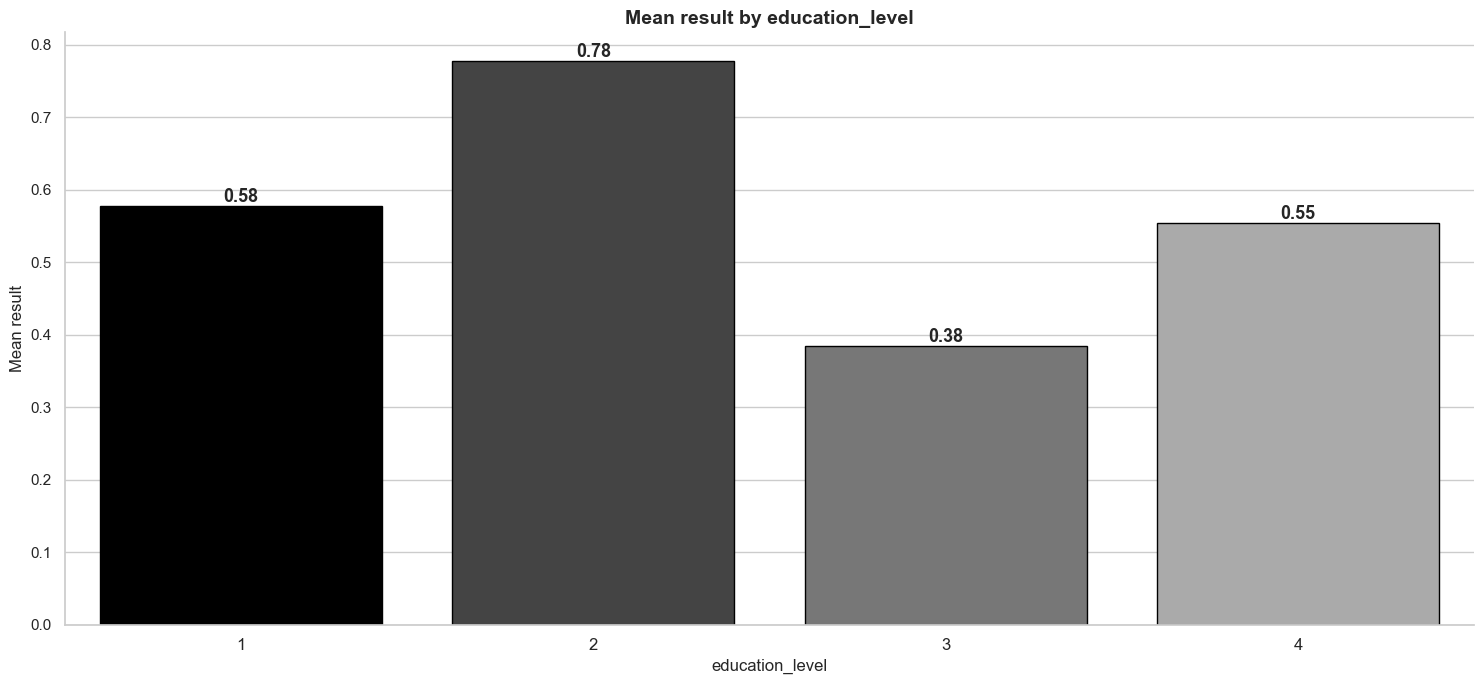

C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


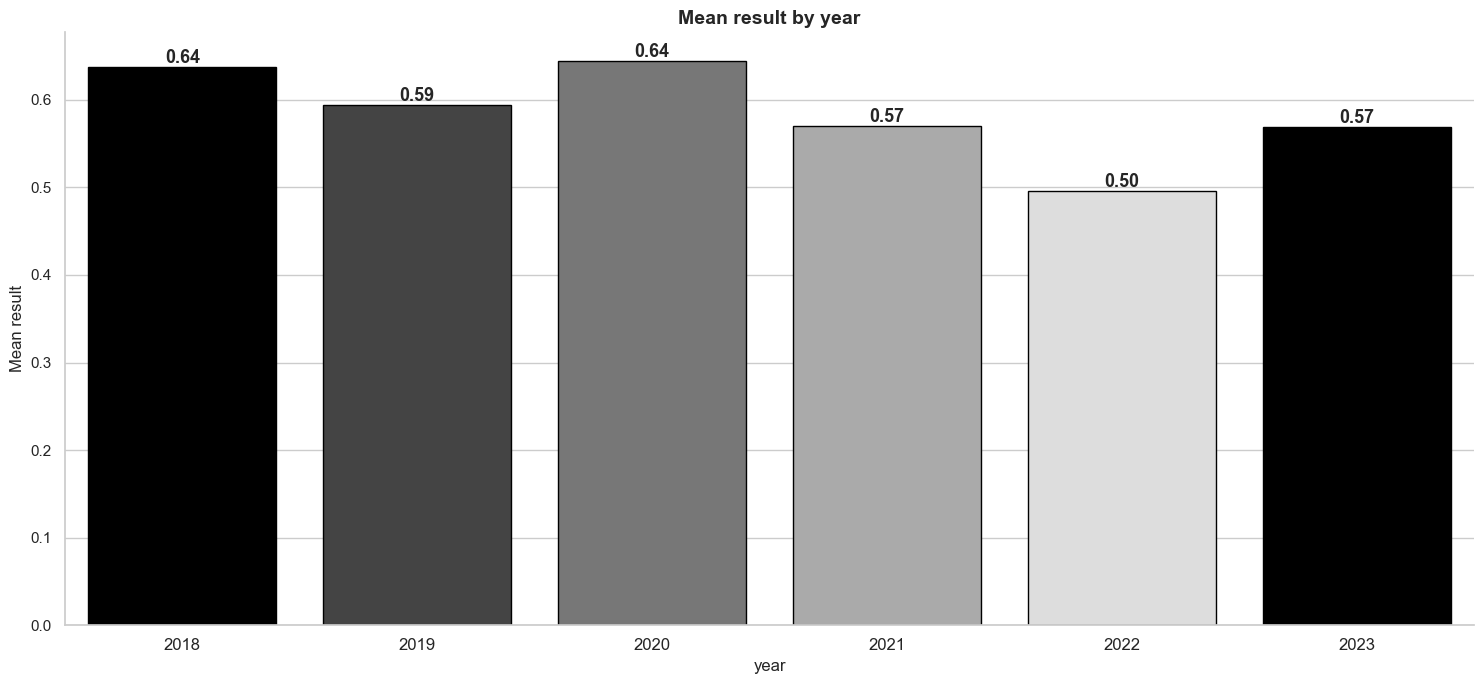

C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


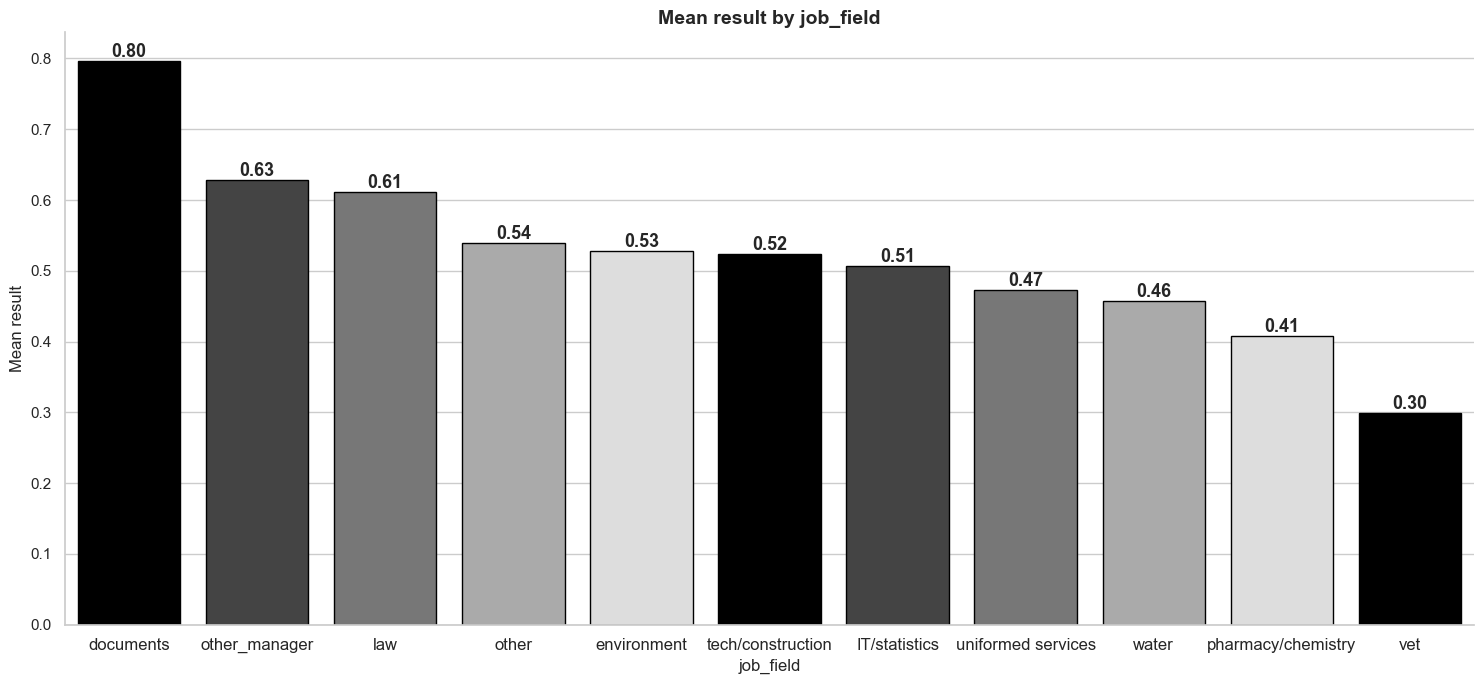

C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_9664\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


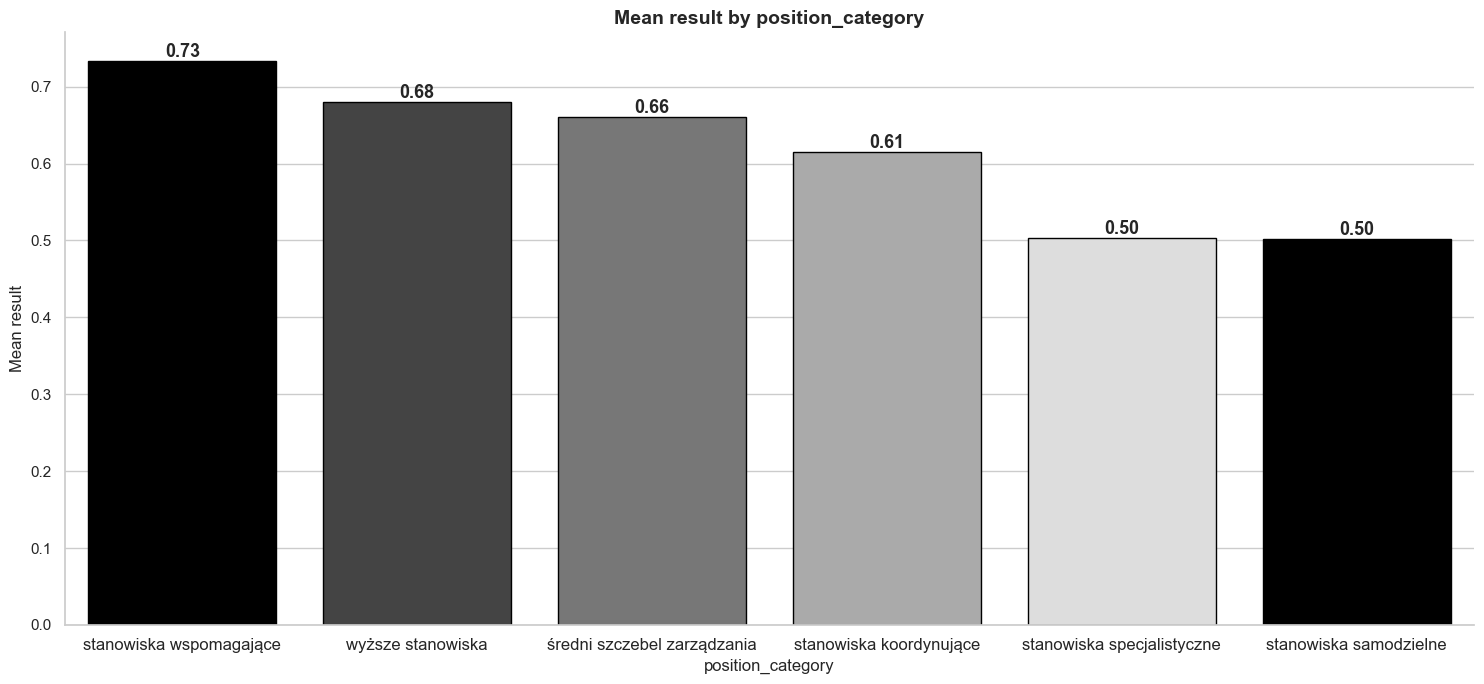

In [20]:
plot_bar_columns = [
    'education_level',
    'year',
    'job_field',
    'position_category'
]

for column in plot_bar_columns:
    plot_ibcs_bar_chart(df, column)

In [21]:
# Dealing with categorical columns.
df = pd.get_dummies(df, columns=['position_category', 'job_field'], drop_first=True, dtype=int)

##### Time series

In [22]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'date_announced',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position',
    'vacancies'
]

df_for_charts = df.drop(string_cols_for_temporary_dropping, axis=1)
df_for_charts["voivodeship_district"] = df_for_charts['voivodeship'].astype(str) + df_for_charts['district'].astype(str)

In [23]:
# def plot_individual_time_series(dataframe):
#     exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time', 'institution']
#     df_grouped = dataframe.groupby('year').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} Over Time", fontsize=16, weight='bold')
#         plt.xlabel("Year", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
#         
# plot_individual_time_series(df_for_charts)

##### Variability charts

In [24]:
# def plot_variability(dataframe):
#     exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']
#     df_grouped = dataframe.groupby('district').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} District Variability", fontsize=16, weight='bold')
#         plt.xlabel("District", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(rotation=45, fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
# 
# plot_variability(df_for_charts)

##### Spaghetti plots

In [25]:
df_for_charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99330 entries, 0 to 99329
Data columns (total 38 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   result                                         99330 non-null  int64  
 1   education_level                                99330 non-null  int64  
 2   institution                                    99330 non-null  object 
 3   ad_views                                       99330 non-null  float64
 4   year                                           99330 non-null  int64  
 5   salary_for_position                            99330 non-null  float64
 6   fluctuation                                    99330 non-null  float64
 7   employment_contract                            99330 non-null  float64
 8   voivodeship                                    99330 non-null  int64  
 9   district                                       993

In [26]:
df_for_charts_district_agg = df_for_charts.groupby(by=['voivodeship_district', 'year'])['result'].mean()
df_for_charts_institution_agg = df_for_charts.groupby(by=['institution', 'year'])['result'].mean()

In [27]:
def plot_spaghetti_chart(df_grouped, group_cols):
    df = df_grouped.reset_index()
    
    groups = df.groupby(group_cols)

    plt.figure(figsize=(10, 6))
    for group_vals, group_data in groups:
        label = '-'.join(map(str, group_vals)) if isinstance(group_vals, tuple) else str(group_vals)
        plt.plot(group_data['year'], group_data['result'], label=label)

    plt.xlabel('Year')
    plt.ylabel('Result')
    plt.title('Spaghetti Chart')
    plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_9664\3387404042.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


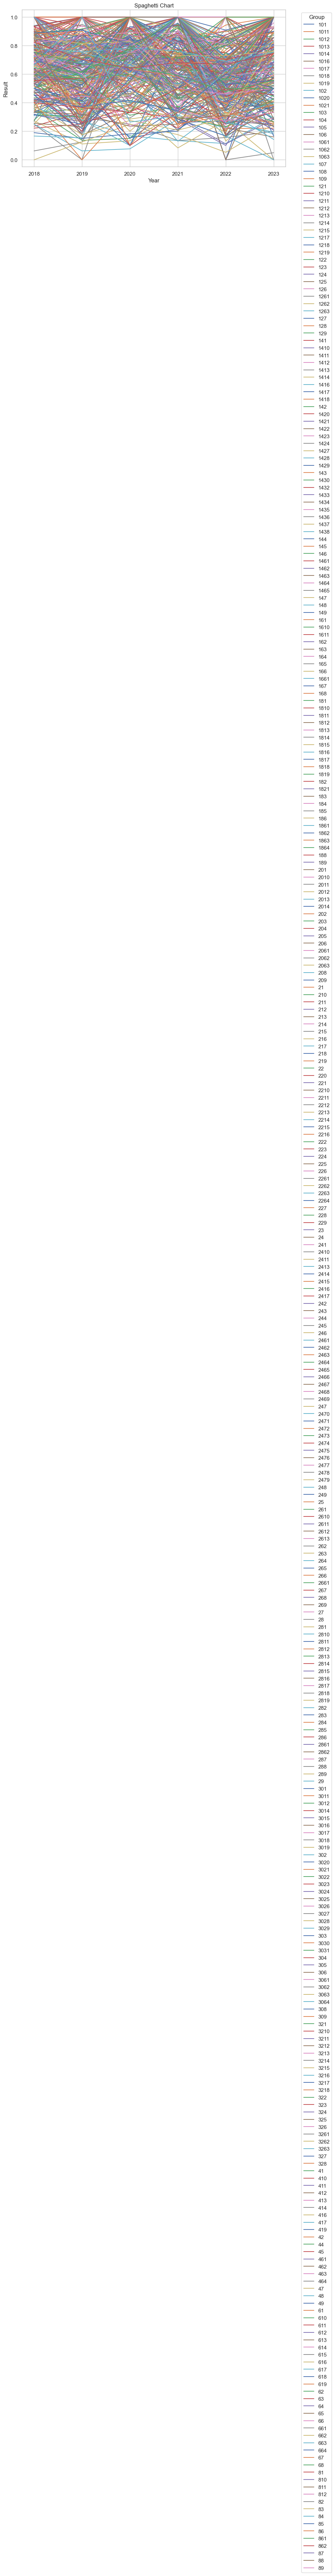

In [28]:
plot_spaghetti_chart(df_for_charts_district_agg, ['voivodeship_district'])

In [29]:
# plot_spaghetti_chart(df_for_charts_institution_agg, ['institution'])

## Feature importance

##### Generalized Linear Mixed Models

In [30]:
df_model = df.drop(string_cols_for_temporary_dropping, axis=1)
df_model['voivodeship_district'] = df_model['voivodeship'].astype(str) + df_model['district'].astype(str)
df_model.drop(['voivodeship', 'district'], axis=1, inplace=True)

In [31]:
# Making year a categorical col
df_model = pd.get_dummies(df_model, columns=['year'], drop_first=True, dtype=int)

In [32]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99330 entries, 0 to 99329
Data columns (total 40 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   result                                         99330 non-null  int64  
 1   education_level                                99330 non-null  int64  
 2   institution                                    99330 non-null  object 
 3   ad_views                                       99330 non-null  float64
 4   salary_for_position                            99330 non-null  float64
 5   fluctuation                                    99330 non-null  float64
 6   employment_contract                            99330 non-null  float64
 7   foreign_capital                                99330 non-null  float64
 8   unemployment                                   99330 non-null  float64
 9   bdl_age_median                                 993

In [48]:
df_model = pd.read_csv('df_model.csv')

In [49]:
df_model = df_model.iloc[0:1000, :]

In [50]:
# Standarization.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = df_model.drop(['result', 'institution', 'voivodeship_district'], axis=1)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled_df = pd.concat([X_train_scaled_df, df_model[['result', 'institution', 'voivodeship_district']]], axis=1)

In [51]:
X_train_scaled_df.head()

,Unnamed: 0,education_level,ad_views,salary_for_position,fluctuation,employment_contract,foreign_capital,unemployment,bdl_age_median,bdl_average_salary,...,job_field_vet,job_field_water,year_2019,year_2020,year_2021,year_2022,year_2023,result,institution,voivodeship_district
0,-1.730320,0.305500,-1.427751,0.500238,0.500238,-0.768948,-0.790055,0.464161,1.041324,-1.306061,...,2.787818,-0.031639,0.0,0.0,0.0,0.0,0.0,1,Powiatowy Inspektorat Weterynarii w Oleśnie,168
1,-1.726856,0.305500,-1.167497,0.616378,0.616378,-0.747680,-0.672265,-0.455425,1.092307,-0.384024,...,-0.358703,-0.031639,0.0,0.0,0.0,0.0,0.0,0,Wojewódzki Inspektorat Nadzoru Budowlanego w B...,461
2,-1.723391,-0.781688,-0.234728,-0.371049,-0.371049,-0.779799,-0.753132,0.923953,1.296239,-0.821009,...,2.787818,-0.031639,0.0,0.0,0.0,0.0,0.0,1,Powiatowy Inspektorat Weterynarii w Chrzanowie,123
3,-1.719927,1.392688,-0.798996,0.222001,0.222001,0.832176,1.553757,-0.685321,-0.794058,1.235496,...,-0.358703,-0.031639,0.0,0.0,0.0,0.0,0.0,0,Komenda Stołeczna Policji w Warszawie,1465
4,-1.716463,0.305500,-1.324110,0.264886,0.264886,-0.776268,-0.655396,1.153850,1.041324,-0.922167,...,2.787818,-0.031639,0.0,0.0,0.0,0.0,0.0,1,Powiatowy Inspektorat Weterynarii w Świdnicy,219


In [52]:
df_model = X_train_scaled_df

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

# Make sure you have patsy installed: pip install patsy
from patsy.highlevel import dmatrix

import dalex as dx
import matplotlib.pyplot as plt
import sys # Import sys for controlled exit

# --- Configuration ---
# Define your outcome variable and grouping variables explicitly
# Make sure these column names exactly match those in your df_model
OUTCOME_VAR = 'result'
GROUPING_VAR_LEVEL1 = 'institution' # Inner grouping level (e.g., specific institution)
GROUPING_VAR_LEVEL2 = 'voivodeship_district' # Outer grouping level (e.g., broader administrative area)

# --- Identify Fixed Effect Predictors (Moved Here - BEFORE cleaning steps that might use this list) ---
# These are columns that are NOT the outcome, grouping variables, or known generated IDs.
# This definition must come AFTER df_model is available.
if 'df_model' in locals() and isinstance(df_model, pd.DataFrame):
    fixed_effect_cols = [col for col in df_model.columns if col not in [
        OUTCOME_VAR,
        GROUPING_VAR_LEVEL1,
        GROUPING_VAR_LEVEL2,
        'nested_institution_id' # Exclude this ID column even if not yet created, for robustness
    ]]
    print(f"\nIdentified Fixed Effect Predictors (before cleaning): {fixed_effect_cols}")
else:
    print("\nCRITICAL ERROR: df_model is not loaded or defined before identifying fixed_effect_cols.")
    print("Please ensure your data is loaded into a pandas DataFrame named 'df_model'.")
    sys.exit(1) # Exit if df_model isn't ready

# --- Placeholder for Handling Categorical Fixed Effects ---
# If your actual data has categorical columns in `fixed_effect_cols` (e.g., string types),
# you MUST convert them to numeric dummy variables before they are used by statsmodels.
# Example:
# categorical_predictors = ['col_A', 'col_B'] # List of your categorical predictor column names
# df_model = pd.get_dummies(df_model, columns=categorical_predictors, drop_first=True)
# # After pd.get_dummies, you might need to update `fixed_effect_cols` if it was defined broadly:
# fixed_effect_cols = [col for col in df_model.columns if col not in [
#     OUTCOME_VAR, GROUPING_VAR_LEVEL1, GROUPING_VAR_LEVEL2, 'nested_institution_id'
#     # also exclude original categorical_predictors names if they are still in df_model.columns and not dummies
# ]]
# print(f"\nUpdated Fixed Effect Predictors (after potential dummification): {fixed_effect_cols}")
# --- End of Placeholder ---


print("\n--- Your df_model Head (first 5 rows) ---")
print(df_model.head())
print("\n--- df_model Info ---")
df_model.info()
print("\n--- df_model Missing Values (Before Cleaning) ---")
print(df_model.isnull().sum())


# --- IMPORTANT: Data Cleaning and Type Coercion ---
# This step is crucial to prevent 'object' dtype errors and empty sequences.

# Identify all columns relevant to the model
model_cols = [OUTCOME_VAR] + fixed_effect_cols + [GROUPING_VAR_LEVEL1, GROUPING_VAR_LEVEL2]

# Coerce potentially numeric columns to numeric, turning errors into NaN
# This assumes fixed_effect_cols are already numeric or have been dummified.
for col in fixed_effect_cols + [OUTCOME_VAR]:
    if col in df_model.columns:
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Ensure grouping variables are strings and replace 'nan' string with actual NaN, then fill NaNs
for col in [GROUPING_VAR_LEVEL1, GROUPING_VAR_LEVEL2]:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(str).replace('nan', np.nan)

# Drop rows where any of the critical model columns have NaN values
initial_rows = len(df_model)
df_model.dropna(subset=model_cols, inplace=True)
if len(df_model) < initial_rows:
    print(f"\nINFO: Dropped {initial_rows - len(df_model)} rows due to NaN values in critical model columns after type coercion.")
else:
    print("\nINFO: No rows dropped due to NaN values in critical model columns.")

# --- CRITICAL CHECK: Ensure DataFrame is not empty after cleaning ---
if df_model.empty:
    print("\nERROR: DataFrame is empty after cleaning and dropping rows with NaN values.")
    print("This means there's no data left to build the model.")
    print("Please check your input data for excessive missing values or consider an imputation strategy.")
    sys.exit(1) # Exit the script if DataFrame is empty

print("\n--- df_model Info (After Cleaning) ---")
df_model.info()
print("\n--- df_model Missing Values (After Cleaning) ---")
print(df_model.isnull().sum())
if df_model.isnull().sum().sum() > 0:
    print("\nWARNING: Some NaNs still exist in non-model-critical columns or remaining NaNs are not handled.")


# --- 1. Identify Variables and Prepare Data for Statsmodels BinomialBayesMixedGLM ---

# fixed_effect_cols is already defined. Confirming the list to be used:
print(f"\nUsing Fixed Effect Predictors for model building: {fixed_effect_cols}")

# Prepare endog (dependent variable)
endog = df_model[OUTCOME_VAR]

# Prepare exog (fixed effects design matrix)
# This assumes fixed_effect_cols contains only numeric columns (original or dummified)
exog = sm.add_constant(df_model[fixed_effect_cols], prepend=True)

# For nested random effects, create a unique combined group ID
df_model['nested_institution_id'] = df_model[GROUPING_VAR_LEVEL2].astype(str) + '_' + df_model[GROUPING_VAR_LEVEL1].astype(str)

# Define the random effects design matrices for BinomialBayesMixedGLM.
# We need to combine all random effect dummy variables into a single exog_vc matrix.

# Random intercepts for `voivodeship_district` (Level 2)
try:
    vc_voivodeship_dummies = dmatrix('0 + C(voivodeship_district)', data=df_model, return_type='dataframe')
    if vc_voivodeship_dummies.shape[1] == 0:
        print(f"\nWARNING: 'voivodeship_district' resulted in 0 dummy variables. Check unique values and data after cleaning.")
except Exception as e:
    print(f"\nERROR: patsy.dmatrix failed for 'voivodeship_district': {e}")
    vc_voivodeship_dummies = pd.DataFrame(index=df_model.index) # Create empty dataframe with correct index

# Random intercepts for `institution` nested within `voivodeship_district` (Level 1)
try:
    vc_institution_nested_dummies = dmatrix('0 + C(nested_institution_id)', data=df_model, return_type='dataframe')
    if vc_institution_nested_dummies.shape[1] == 0:
        print(f"\nWARNING: 'nested_institution_id' resulted in 0 dummy variables. Check unique values and data after cleaning.")
except Exception as e:
    print(f"\nERROR: patsy.dmatrix failed for 'nested_institution_id': {e}")
    vc_institution_nested_dummies = pd.DataFrame(index=df_model.index) # Create empty dataframe with correct index

# Get number of dummies created
num_voivodeship_dummies = vc_voivodeship_dummies.shape[1]
num_institution_nested_dummies = vc_institution_nested_dummies.shape[1]


# Concatenate these dummy matrices horizontally to form a single exog_vc
exog_vc_combined = pd.concat([vc_voivodeship_dummies, vc_institution_nested_dummies], axis=1)

# --- CRITICAL CHECK: Ensure combined random effects matrix is not empty ---
if exog_vc_combined.empty or exog_vc_combined.shape[1] == 0:
    print("\nERROR: The combined random effects design matrix (exog_vc_combined) is empty or has no columns.")
    print("This means no random effects could be modeled. Ensure your grouping variables have unique, non-NaN values after cleaning.")
    print("BinomialBayesMixedGLM requires at least one random effect component to be specified.")
    sys.exit(1) # Exit the script if no random effects can be modeled


# Define the 'ident' argument:
ident_list_components = []
if num_voivodeship_dummies > 0:
    ident_list_components.extend([0] * num_voivodeship_dummies) # Component 0 for voivodeship
if num_institution_nested_dummies > 0:
    ident_list_components.extend([1] * num_institution_nested_dummies) # Component 1 for nested institution

ident = np.array(ident_list_components, dtype=int)

# --- 2. Build the GLMM in Statsmodels using BinomialBayesMixedGLM ---
print("\n--- Building Statsmodels BinomialBayesMixedGLM Model ---")

glmm_model = BinomialBayesMixedGLM(
    endog=endog,
    exog=exog,
    exog_vc=exog_vc_combined,
    ident=ident
)

# --- 3. Fit the Statsmodels GLMM Model ---
print("\n--- Fitting Statsmodels BinomialBayesMixedGLM Model (This may take a moment) ---")
# Użyj fit_map() lub fit_vb() zamiast fit(), aby uzyskać obiekt wyników
glmm_results = glmm_model.fit_map()


# --- 4. Summarize the Statsmodels GLMM Model ---
print("\n--- Statsmodels BinomialBayesMixedGLM Model Summary ---")
print(glmm_results.summary())

# --- 5. Create a Predict Function for Dalex ---
def predict_statsmodels_glmm_probs(model_or_explainer, X_new_df):
    """
    Predicts the marginal probabilities of success (0-1) for new data using the fitted Statsmodels GLMM.
    This prediction assumes random effects are averaged out (effectively zero).
    It requires X_new_df to contain only the fixed effect columns with the same names and order
    as used in training, and they must be numeric.

    Note: The 'model_or_explainer' argument is added because Dalex sometimes passes the explainer object
    or model itself as the first argument to the predict_function. We won't use it directly here,
    as glmm_results is already available from the outer scope.
    """
    # Ensure X_new_df has the same columns as fixed_effect_cols from training
    X_new_exog_df = X_new_df[fixed_effect_cols].copy()
    X_new_exog = sm.add_constant(X_new_exog_df, prepend=True)
    
    # Make sure columns are in the same order as original exog if it matters
    # (Typically statsmodels handles by name, but good practice)
    X_new_exog = X_new_exog[exog.columns] # exog was used for fitting

    predictions_probs = glmm_results.predict(exog=X_new_exog)
    return predictions_probs

# --- 6. Initialize Dalex Explainer ---
print("\n--- Initializing Dalex Explainer ---")
# The data for dalex should be only the fixed effect features.
X_for_dalex = df_model[fixed_effect_cols].copy() # Only fixed effects for Dalex
y_for_dalex = df_model[OUTCOME_VAR].copy() # The actual binary result

explainer = dx.Explainer(
    model=glmm_results, # Can pass the fitted model directly if it has a predict_proba or predict method
                        # OR our custom predict_statsmodels_glmm_probs
    # For BinomialBayesMixedGLM, predict() gives probabilities.
    # Let's test if Dalex can use our custom predict function more robustnie.
    # model=predict_statsmodels_glmm_probs, # Use this if glmm_results directly is problematic
    data=X_for_dalex,
    y=y_for_dalex,
    label="Job Ad GLMM (Statsmodels)",
    predict_function=predict_statsmodels_glmm_probs # Explicitly pass custom predict function
)

# --- 7. Get Variable Importance using Dalex (Permutation Importance) ---
print("\n--- Calculating Dalex Permutation Importance for Fixed Effects (This may take a moment) ---")
mp_explanation = explainer.model_parts(N=100, random_state=42) # Increase N for more robustness, add random_state for reproducibility

print("\n--- Dalex Permutation Importance Results ---")
print(mp_explanation.result)

# Plot the permutation importance
print("\n--- Plotting Dalex Permutation Importance ---")
mp_explanation.plot()
plt.title("Permutation Importance for Job Ad GLMM Fixed Effects")
plt.tight_layout()
plt.show()

# --- 8. Optional: Single Prediction Explanation (Breakdown) ---
print("\n--- Calculating Breakdown Explanation for a Single Job Ad ---")
if not X_for_dalex.empty:
    random_obs_idx = np.random.randint(0, len(X_for_dalex))
    observation_to_explain = X_for_dalex.iloc[[random_obs_idx]]

    # Zmień predict_breakdown na predict_parts
    bd_explanation = explainer.predict_parts(observation_to_explain)

    print(f"\n--- Breakdown Explanation Results (Job Ad Index {random_obs_idx}) ---")
    print(bd_explanation.result)

    # Plot the breakdown explanation
    print("\n--- Plotting Breakdown Explanation ---")
    # Use explainer.predict for a single observation to get the predicted value for the title
    predicted_prob = explainer.predict(observation_to_explain)[0] # explainer.predict calls our predict_function

    plt.figure(figsize=(10, 6))
    bd_explanation.plot()
    plt.title(f"Breakdown for Job Ad (Index {random_obs_idx}, Predicted Probability: {predicted_prob:.2f})")
    plt.tight_layout()
    plt.show()
else:
    print("\nINFO: Skipping Breakdown Explanation as X_for_dalex is empty.")

print("\n--- Script Finished ---")


Identified Fixed Effect Predictors (before cleaning): ['Unnamed: 0', 'education_level', 'ad_views', 'salary_for_position', 'fluctuation', 'employment_contract', 'foreign_capital', 'unemployment', 'bdl_age_median', 'bdl_average_salary', 'bdl_avg_house_pricing', 'bdl_migration_coefficient', 'work_time_over_1', 'full_time_job', 'work_time_below_1', 'offer_salary_mentioned', 'len_requirements', 'len_responsibilities', 'position_category_stanowiska samodzielne', 'position_category_stanowiska specjalistyczne', 'position_category_stanowiska wspomagające', 'position_category_wyższe stanowiska', 'position_category_średni szczebel zarządzania', 'job_field_documents', 'job_field_environment', 'job_field_law', 'job_field_other', 'job_field_other_manager', 'job_field_pharmacy/chemistry', 'job_field_tech/construction', 'job_field_uniformed services', 'job_field_vet', 'job_field_water', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023']

--- Your df_model Head (first 5 rows) ---
   Unn

##### Conclusions

In [ ]:
# # As a result of the above analyses, I decided to exclude certain columns due to their low variability or low correlation.
# 
# cols_to_exclude = [
#     'women_percentage',
#     'bdl_feminization_coefficient',
#     'work_time',
#     'job_field_documents',
#     'job_field_environment',
#     'bdl_age_median',
#     'job_field_water',
#     'bdl_avg_house_pricing',
#     'vacancies',
#     'fluctuation',
#     'salary_for_position'
# ]
# 
# df_institution_level = df_institution_level.drop(columns=cols_to_exclude, axis=1)